<IPython.core.display.Javascript object>


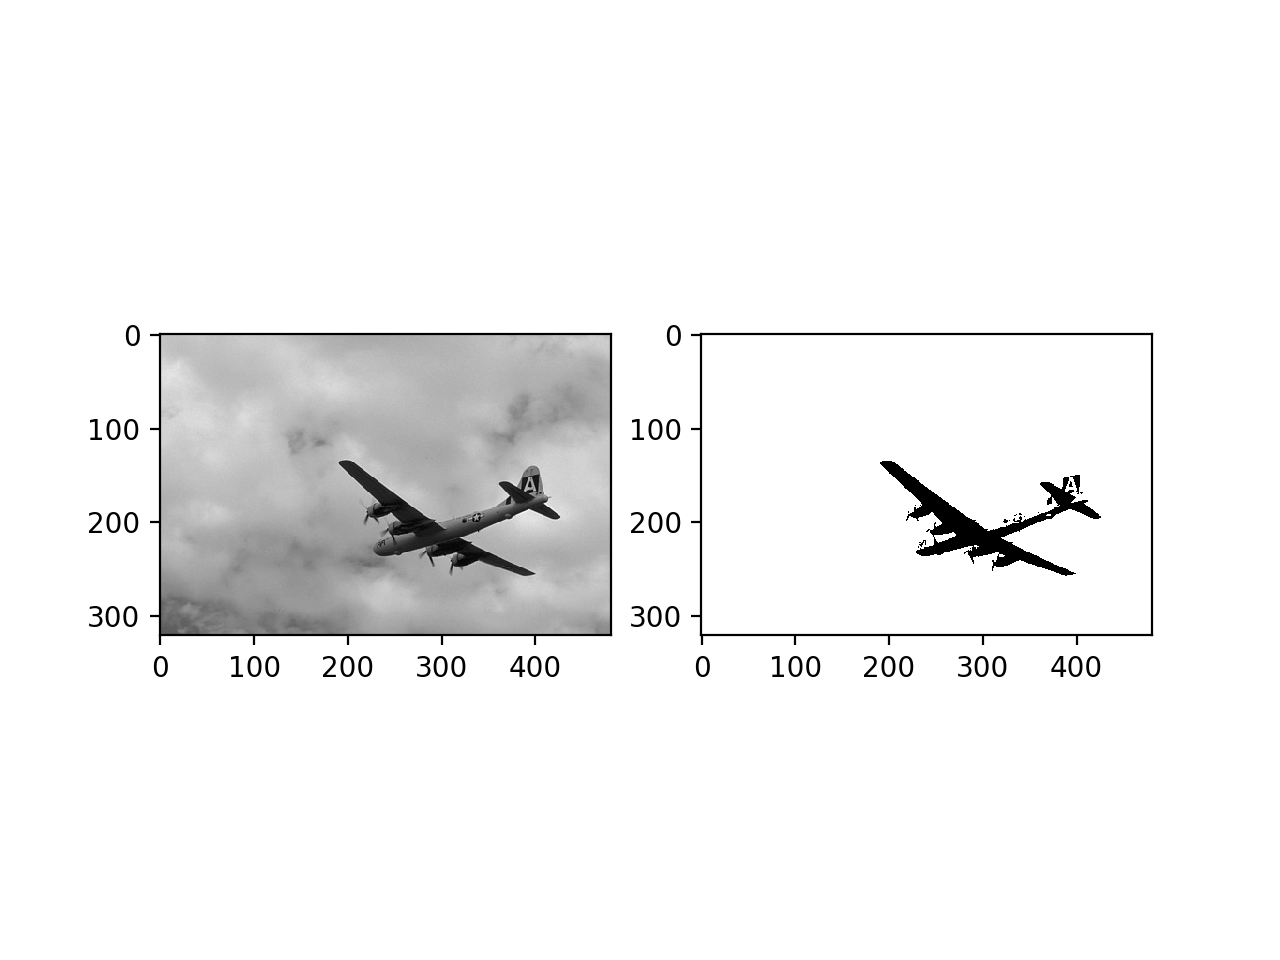

In [5]:
%matplotlib notebook
import numpy as np
import cv2 as cv
import matplotlib
from matplotlib import pyplot as plt


def max_entropy(hist):
    """
    Implements Kapur-Sahoo-Wong (Maximum Entropy) thresholding method
    Kapur J.N., Sahoo P.K., and Wong A.K.C. (1985) "A New Method for Gray-Level Picture Thresholding Using the Entropy
    of the Histogram", Graphical Models and Image Processing, 29(3): 273-285
    参考：https://github.com/zenr/ippy/blob/master/segmentation/max_entropy.py
    Params:
        hist [np.array]: 图像灰度直方图。（未归一化的）
    Return:
        threshold [int]: threshold calculated by 一维最大熵算法
    """

    # calculate normalized CDF (cumulative density function)
    cdf = hist.cumsum()
    cdf_normal = cdf / cdf[-1]
    hist_normal = hist / cdf[-1]

    valid_range = np.nonzero(hist_normal)[0]
    s_range = hist_normal[hist_normal != 0]
    H_s_cum = -np.cumsum(s_range * np.log(s_range))

    H_n = H_s_cum[-1]

    max_ent, threshold = 0, 0
    for i in range(len(H_s_cum) - 1): # 忽略最后一个非零点，防止P_s为1导致(1 - P_s)为0
        s = valid_range[i]
        P_s = cdf_normal[s]
        H_s = H_s_cum[i]
        total_ent = np.log(P_s * (1 - P_s)) + H_s/P_s + (H_n - H_s)/(1 - P_s)

        # find max
        if total_ent > max_ent:
            max_ent, threshold = total_ent, s

    return threshold

img_name = 'img/airplane.jpg'
img = cv.imread(img_name, cv.IMREAD_GRAYSCALE)

lap_img = abs(cv.Laplacian(img, -1))
lap_hist = cv.calcHist([lap_img], [0], None, [256], [0,256])

T = np.max(lap_img) * 0.2 # 阈值取拉普拉斯图像中最大值的xx%
_, mask = cv.threshold(lap_img, T, 255, cv.THRESH_BINARY)
masked_img = cv.bitwise_and(img, img, mask=mask)
masked_img_hist = cv.calcHist([img], [0], mask, [256], [0,256])

threshold = max_entropy(masked_img_hist.ravel())
_, thr_img = cv.threshold(img, threshold, 255, cv.THRESH_BINARY)

plt.subplot(1, 2, 1)
plt.imshow(img, 'gray')
plt.subplot(1, 2, 2)
plt.imshow(thr_img, 'gray')